## Extending the Likelihood-Based Approach to Item Repetition Data

In [1]:
#| code-summary: code -- 1) load dependencies and data
from compmemlearn.fitting import lohnas_objective_function, apply_and_concatenate
from compmemlearn.analyses import sim_recall_probability_by_lag, recall_probability_by_lag
from compmemlearn.datasets import prepare_lohnas2014_data, simulate_data, simulate_array, simulate_array_from_presentations
from compmemlearn.analyses import fast_csp
from compmemlearn.models import Classic_CMR
from scipy.optimize import differential_evolution
from numba.typed import List, Dict
import matplotlib.pyplot as plt
from numba.core import types
from numba import njit
import seaborn as sns
from psifr import fr
import pandas as pd
import numpy as np

trials, events, list_length, presentations, list_types, rep_data, subjects = prepare_lohnas2014_data(
    '../../data/repFR.mat')

cmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate'
)

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

cmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(fastmath=True, nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)


### Fit to Entire Dataset

In [24]:
selection = list_types > 0
cost_function = lohnas_objective_function(
    trials[selection], 
    presentations[selection],
    init_cmr,
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    cmr_free_parameters)

cmr_result = differential_evolution(cost_function, cmr_bounds, disp=True)

differential_evolution step 1: f(x)= 74467.9
differential_evolution step 2: f(x)= 74467.9
differential_evolution step 3: f(x)= 74467.9
differential_evolution step 4: f(x)= 70439.8
differential_evolution step 5: f(x)= 70439.8
differential_evolution step 6: f(x)= 66439.2
differential_evolution step 7: f(x)= 65767
differential_evolution step 8: f(x)= 65767
differential_evolution step 9: f(x)= 65269
differential_evolution step 10: f(x)= 65269
differential_evolution step 11: f(x)= 64503.3
differential_evolution step 12: f(x)= 64503.3
differential_evolution step 13: f(x)= 64454.7
differential_evolution step 14: f(x)= 62702.9
differential_evolution step 15: f(x)= 62702.9
differential_evolution step 16: f(x)= 62670
differential_evolution step 17: f(x)= 61826.3
differential_evolution step 18: f(x)= 61826.3
differential_evolution step 19: f(x)= 61826.3
differential_evolution step 20: f(x)= 61788.2
differential_evolution step 21: f(x)= 61788.2
differential_evolution step 22: f(x)= 61123.2
differe

In [25]:
#| include: false
print(cmr_result)

     fun: 60797.221058367635
     jac: array([ -0.38417056,   0.12878445,   0.94878487, -17.76206772,
        -0.31868694,   0.26702764,  -0.03055902,   0.        ,
        -0.02910383,  -2.83689588,   1.26674423,   0.75815478])
 message: 'Optimization terminated successfully.'
    nfev: 8005
     nit: 33
 success: True
       x: array([8.65828835e-01, 2.26715503e-01, 9.52028097e-01, 2.63844603e-02,
       1.47259363e-07, 4.31890546e-01, 2.63745217e+00, 2.98606729e+01,
       2.51644003e-02, 1.01406301e-01, 1.02305123e+00, 9.80106784e-01])


```
     fun: 60797.221058367635
     jac: array([ -0.38417056,   0.12878445,   0.94878487, -17.76206772,
        -0.31868694,   0.26702764,  -0.03055902,   0.        ,
        -0.02910383,  -2.83689588,   1.26674423,   0.75815478])
 message: 'Optimization terminated successfully.'
    nfev: 8005
     nit: 33
 success: True
       x: array([8.65828835e-01, 2.26715503e-01, 9.52028097e-01, 2.63844603e-02,
       1.47259363e-07, 4.31890546e-01, 2.63745217e+00, 2.98606729e+01,
       2.51644003e-02, 1.01406301e-01, 1.02305123e+00, 9.80106784e-01])
```

In [26]:
#| code-summary: code -- 3) with PrototypeCMR, compose simulated recall_probability_by_lag from overall fitting results
#| output: false

parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for index, name in enumerate(cmr_free_parameters):
    parameters[name] = cmr_result.x[index]
    
parameters['sampling_rule'] = 0
parameters['mfc_familiarity_scale'] = 0
parameters['mcf_familiarity_scale'] = 0
parameters['drift_familiarity_scale'] = 0

# recall probability by lag
selection = list_types == 4
result = sim_recall_probability_by_lag(
    presentations[selection], 10, init_cmr, parameters)
binned = np.zeros(5)
binned[0] = result[0]
binned[1] = result[1]
binned[2] = (result[2] + result[3])/2
binned[3] = (result[4] + result[5] + result[6])/3
binned[4] = (result[7] + result[8] + result[9])/3
sim_rpl = binned.copy()

result = recall_probability_by_lag(
    presentations[selection], trials[selection], max_lag=8)
binned = np.zeros(5)
binned[0] = result[0]
binned[1] = result[1]
binned[2] = (result[2] + result[3])/2
binned[3] = (result[4] + result[5] + result[6])/3
binned[4] = (result[7] + result[8] + result[9])/3
true_rpl = binned.copy()

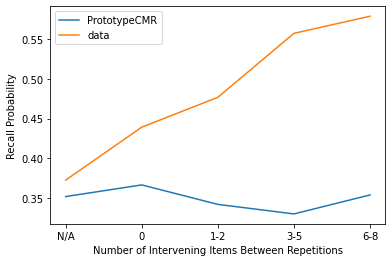

In [27]:
ax = sns.lineplot(x=['N/A', '0', '1-2', '3-5', '6-8'], 
                 y=sim_rpl, label='PrototypeCMR')
ax = sns.lineplot(x=['N/A', '0', '1-2', '3-5', '6-8'], 
                 y=true_rpl, label='data')
plt.xlabel('Number of Intervening Items Between Repetitions')
plt.ylabel('Recall Probability')
plt.show()

In [76]:
full_fit = np.array([8.65828835e-01, 2.26715503e-01, 9.52028097e-01, 2.63844603e-02,
       1.47259363e-07, 4.31890546e-01, 2.63745217e+00, 2.98606729e+01,
       2.51644003e-02, 1.01406301e-01, 1.02305123e+00, 9.80106784e-01])

selection = list_types == 4
cost_function = lohnas_objective_function(
    trials[selection], 
    presentations[selection],
    init_cmr,
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    cmr_free_parameters)

cost_function(full_fit)

17293.838649394795

### Fit Just to Condition 4

In [2]:
selection = list_types == 4
cost_function = lohnas_objective_function(
    trials[selection], 
    presentations[selection],
    init_cmr,
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    cmr_free_parameters)

cmr_result = differential_evolution(cost_function, cmr_bounds, disp=True)

print(cmr_result)

differential_evolution step 1: f(x)= 20543
differential_evolution step 2: f(x)= 19563.3
differential_evolution step 3: f(x)= 19563.3
differential_evolution step 4: f(x)= 18712.6
differential_evolution step 5: f(x)= 18712.6
differential_evolution step 6: f(x)= 18581.8
differential_evolution step 7: f(x)= 18477.4
differential_evolution step 8: f(x)= 18081.1
differential_evolution step 9: f(x)= 18081.1
differential_evolution step 10: f(x)= 18081.1
differential_evolution step 11: f(x)= 18081.1
differential_evolution step 12: f(x)= 18081.1
differential_evolution step 13: f(x)= 18076
differential_evolution step 14: f(x)= 17960.3
differential_evolution step 15: f(x)= 17960.3
differential_evolution step 16: f(x)= 17960.3
differential_evolution step 17: f(x)= 17731.8
differential_evolution step 18: f(x)= 17727.2
differential_evolution step 19: f(x)= 17727.2
differential_evolution step 20: f(x)= 17727.2
differential_evolution step 21: f(x)= 17727.2
differential_evolution step 22: f(x)= 17540
dif

```
fun: 17165.456237034767
     jac: array([-8.36735121e-02, -9.20408639e-02,  6.08997649e-01,  1.79352355e-01,
        2.12628947e+01,  8.14907253e-02,  1.27329259e-01,  7.67613529e-02,
        1.46974344e-01,  9.13132681e-02, -2.80124370e-02, -4.36557455e-03])
 message: 'Optimization terminated successfully.'
    nfev: 8860
     nit: 41
 success: True
       x: array([8.44375848e-01, 1.37679001e-01, 9.63178869e-01, 4.89695742e-02,
       2.22044605e-16, 4.31315899e-01, 4.98073649e+00, 4.53976374e-01,
       2.13832687e-02, 1.06850502e-01, 1.21932164e+00, 9.13889145e-01])
```

In [3]:
#| code-summary: code -- 3) with PrototypeCMR, compose simulated recall_probability_by_lag from overall fitting results
#| output: false

from compmemlearn.analyses import sim_recall_probability_by_lag, recall_probability_by_lag


parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for index, name in enumerate(cmr_free_parameters):
    parameters[name] = cmr_result.x[index]
    
parameters['sampling_rule'] = 0
parameters['mfc_familiarity_scale'] = 0
parameters['mcf_familiarity_scale'] = 0
parameters['drift_familiarity_scale'] = 0

# recall probability by lag
selection = list_types == 4
result = sim_recall_probability_by_lag(
    presentations[selection], 10, init_cmr, parameters)
binned = np.zeros(5)
binned[0] = result[0]
binned[1] = result[1]
binned[2] = (result[2] + result[3])/2
binned[3] = (result[4] + result[5] + result[6])/3
binned[4] = (result[7] + result[8] + result[9])/3
sim_rpl = binned.copy()

result = recall_probability_by_lag(
    presentations[selection], trials[selection], max_lag=8)
binned = np.zeros(5)
binned[0] = result[0]
binned[1] = result[1]
binned[2] = (result[2] + result[3])/2
binned[3] = (result[4] + result[5] + result[6])/3
binned[4] = (result[7] + result[8] + result[9])/3
true_rpl = binned.copy()

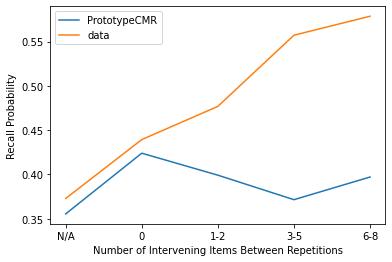

In [4]:
ax = sns.lineplot(x=['N/A', '0', '1-2', '3-5', '6-8'], 
                 y=sim_rpl, label='PrototypeCMR')
ax = sns.lineplot(x=['N/A', '0', '1-2', '3-5', '6-8'], 
                 y=true_rpl, label='data')
plt.xlabel('Number of Intervening Items Between Repetitions')
plt.ylabel('Recall Probability')
plt.show()

### Recall Probability by Spacing, Murdock 1970 Fit

In [13]:
cmr_result = np.array(
    [5.88304182e-01, 3.76144942e-02, 7.51294302e-01, 2.91680115e-01,
       1.00000000e+00, 1.39633721e-01, 5.62625588e+00, 4.28789782e+01,
       2.40537436e-02, 2.61824232e-01, 5.32941045e+00, 9.34036191e-01])

fitted_parameters = Dict.empty(
    key_type=types.unicode_type, value_type=types.float64)
for i in range(len(cmr_result)):
    fitted_parameters[cmr_free_parameters[i]] = cmr_result[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0

selection = selection = list_types == 4
sim_array = simulate_array_from_presentations(init_cmr, fitted_parameters, presentations[selection], 1)

sim_array

array([[40, 28, 38, ...,  0,  0,  0],
       [37, 39, 27, ...,  0,  0,  0],
       [39, 40,  0, ...,  0,  0,  0],
       ...,
       [37, 38, 39, ...,  0,  0,  0],
       [40, 39, 29, ...,  0,  0,  0],
       [28, 27, 31, ...,  0,  0,  0]])

In [14]:
# recall probability by lag
selection = list_types == 4
result = recall_probability_by_lag(
    presentations[selection], sim_array, max_lag=8)
binned = np.zeros(5)
binned[0] = result[0]
binned[1] = result[1]
binned[2] = (result[2] + result[3])/2
binned[3] = (result[4] + result[5] + result[6])/3
binned[4] = (result[7] + result[8] + result[9])/3
sim_rpl = binned.copy()

result = recall_probability_by_lag(
    presentations[selection], trials[selection], max_lag=8)
binned = np.zeros(5)
binned[0] = result[0]
binned[1] = result[1]
binned[2] = (result[2] + result[3])/2
binned[3] = (result[4] + result[5] + result[6])/3
binned[4] = (result[7] + result[8] + result[9])/3
true_rpl = binned.copy()

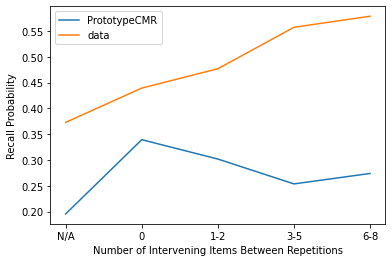

In [15]:
ax = sns.lineplot(x=['N/A', '0', '1-2', '3-5', '6-8'], 
                 y=sim_rpl, label='PrototypeCMR')
ax = sns.lineplot(x=['N/A', '0', '1-2', '3-5', '6-8'], 
                 y=true_rpl, label='data')
plt.xlabel('Number of Intervening Items Between Repetitions')
plt.ylabel('Recall Probability')
plt.show()

In [17]:
true_rpl[1:]

array([0.43928571, 0.47678571, 0.55714286, 0.57857143])